In [6]:
using Dierckx: Spline1D, derivative

In [15]:
import PyPlot
const plt = PyPlot
plt.svg(true)

┌ Info: Recompiling stale cache file /home/efefer/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


true

Initial wavepacket parameters:

In [1]:
# timestep in a.u.
dt = 0.5

# center of Gaussian function
x0 = 0.0

# width parameter for Gaussian wavepacket
β = 9.0

# Initial translational energy in cm^{-1}
energy = 8000.0

# conversion factor from cm^{-1} to a.u.
conv = 219474.6

# Translational energy in a.u.
energy = energy/conv

# Mass in a.u.
am = 2000.0

2000.0

In [22]:
# Barrier height in cm −1
vb = 8000.0
# Barrier height in a.u.
vb = vb/conv
# Center of barrier in a.u.
xb = 6.0
# Width parameter in a.u.
wx = 5.0

5.0

In [2]:
Np = 63
Ntime = 150000

150000

In [12]:
function initial_wavepacket(Np, x0, β; xmin=-0.6, xmax=0.6)

    # Particle spacings
    h = (xmax - xmin)/(Np-1)

    # Normalization for an initial Gaussian wave function
    anorm = (2.0*β/π)^(1.0/4.0)
    
    #Particle positions
    x = zeros(Np)
    
    # Build initial wave packet amplitude and density
    R = zeros(Np)
    C = zeros(Np)
    ρ = zeros(Np)
    for i in 1:Np
        x[i] = xmin + (i-1)*h
        R[i] = anorm*exp( -β*( ( x[i] - x0)^2 ) )
        C[i] = log(R[i])
        ρ[i] = R[i]^2
    end
    
    vx = zeros(Np)
    delv = zeros(Np)
    # Initial particle velocities (all particles are initially the 
    # same velocity and 0 divergence)
    # These velocities are obtained from the equation
    # Etrans = 1/2 * m * v^2 .
    for i in 1:Np
        vx[i] = sqrt(2.0*energy/am)
        delv[i] = 0.0
    end
    
    phase = zeros(Np)
    # Initial phase (action function) for each particle
    for i in 1:Np
        phase[i] = sqrt(2.0*am*energy)*x[i]
    end
    
    return x, R, C, ρ, vx, delv, phase
end

initial_wavepacket (generic function with 1 method)

Calculate first and second derivative:

In [4]:
function calc_deriv!( x, fx, d1x, d2x )
    # interpolant for fx
    spl_fx = Spline1D(x, fx)
    d1x[:] = derivative(spl_fx, x)
    spl_d1x = Spline1D(x, d1x)
    d2x[:] = derivative(spl_d1x, x)
    return
end

calc_deriv! (generic function with 1 method)

In [47]:
x, R, C, ρ, vx, delv, phase = initial_wavepacket(Np, x0, β);

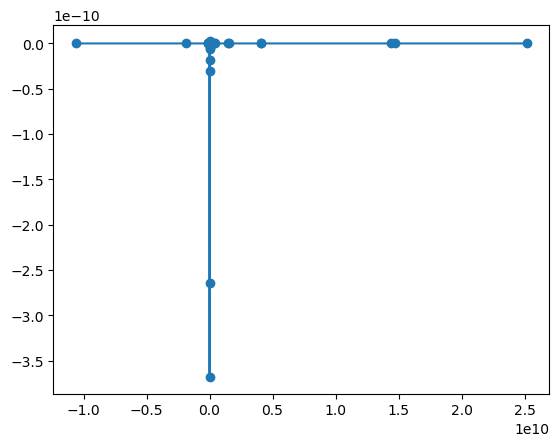

In [48]:
d1x = zeros(Np)
d2x = zeros(Np)
pot = zeros(Np)
Q = zeros(Np)
pot = zeros(Np)

#for k = 1:Ntime
for k = 1:100
    
    t = k*dt
    # conversion from au to fs
    tfs = t*0.0242
    
    calc_deriv!(x, C, d1x, d2x)
    
    # Calculate quantum and classical potentials
    for i in 1:Np
        # Quantum Potential.
        Q[i] = -1.0/(2.0*am)*(d2x[i] + d1x[i]^2)
        # Classical Eckart Potential.
        #pot[i] = vb*sech(wx*(x[i] - x0))^2
        # Harmonic potential
        pot[i] = 0.5*x[i]^2
    end
    
    # Calculate phase (S) using potentials (Quantum Lagrangian: T - (V + Q))
    for i in 1:Np
        KE = 0.5*am*vx[i]^2
        lagrange = KE - ( pot[i] + Q[i] )
        phase[i] = phase[i] + lagrange*dt
    end
    
    # Update particle positions
    for i in 1:Np
        x[i] = x[i] + vx[i]*dt
    end
    
    idx_sorted = sortperm(x)
    x[:]     = x[idx_sorted]
    phase[:] = phase[idx_sorted]
    #vx[:]    = vx[idx_sorted]
    #delv[:]  = delv[idx_sorted]
    ρ[:]     = ρ[idx_sorted]
    C[:]     = C[idx_sorted]
    
    # Call subroutine for spatial derivatives of phase
    calc_deriv!(x, phase, d1x, d2x)
    
    # Update velocities and probability density
    for i in 1:Np
        vx[i] = (1.0/am)*d1x[i]
        delv[i] = (1.0/am)*d2x[i]
        ρ[i] = ρ[i]*exp( -delv[i]*dt )
    end
    
    plt.clf()
    plt.plot(x, ρ, marker="o")
    plt.savefig("TEMP_x_rho_t_"*string(k)*".png", dpi=150)
    
    plt.clf()
    plt.plot(x, pot, marker="o")
    plt.savefig("TEMP_x_pot_t_"*string(k)*".png", dpi=150)
    
    plt.clf()
    plt.plot(x, marker="o")
    plt.savefig("TEMP_traj_x_"*string(k)*".png", dpi=150)
    
    plt.clf()
    plt.plot(x, phase, marker="o")
    plt.savefig("TEMP_x_phase_"*string(k)*".png", dpi=150)
    
    plt.clf()
    plt.plot(x, vx, marker="o")
    plt.savefig("TEMP_x_vx_"*string(k)*".png", dpi=150)
    
    plt.clf()
    plt.plot(x, Q, marker="o")
    plt.savefig("TEMP_x_Q_"*string(k)*".png", dpi=150)
    
end
    

In [29]:
idx = sortperm(x);

In [30]:
x[:] = x[idx];

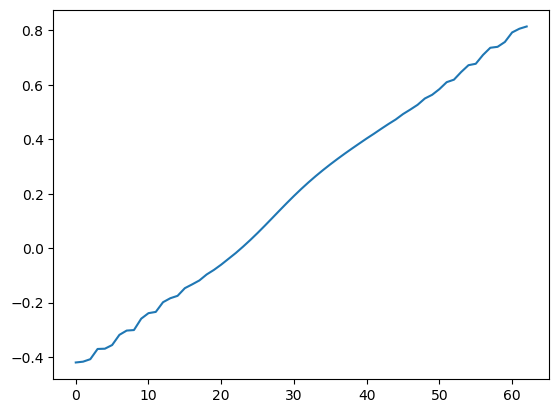

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f987c815710>

In [31]:
plt.clf()
plt.plot(x)

# Test derivative

In [10]:
import PyPlot

┌ Info: Recompiling stale cache file /home/efefer/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


In [11]:
const plt = PyPlot

PyPlot

In [12]:
plt.svg(true)

true

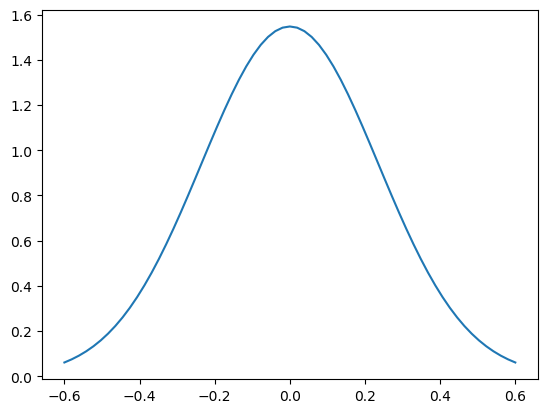

In [15]:
plt.plot(x, R);

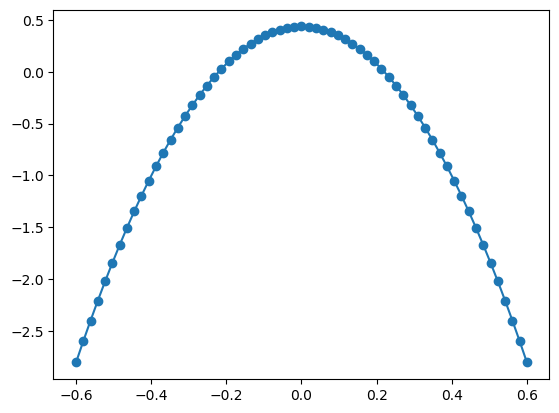

In [19]:
plt.plot(x,C, marker="o");

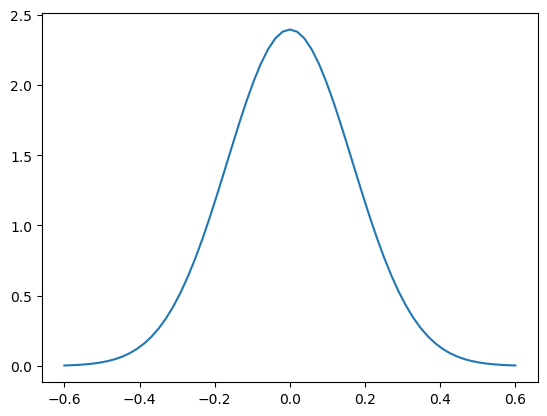

In [18]:
plt.plot(x,ρ);

In [21]:
# Initial particle velocities (all particles are initially the same velocity and 0 divergence)
# These velocities are obtained from the equation 
# Etrans = 1/2 * m * v^2 .
vx = zeros(Np)
delv = zeros(Np)
for i in 1:Np
    vx[i] = sqrt(2.0*energy/am)
end

In [26]:
phase = zeros(Np)
# Initial phase (action function) for each particle
for i in 1:Np
    phase[i] = sqrt(2.0*am*energy)*x[i]
end

In [92]:
using Dierckx

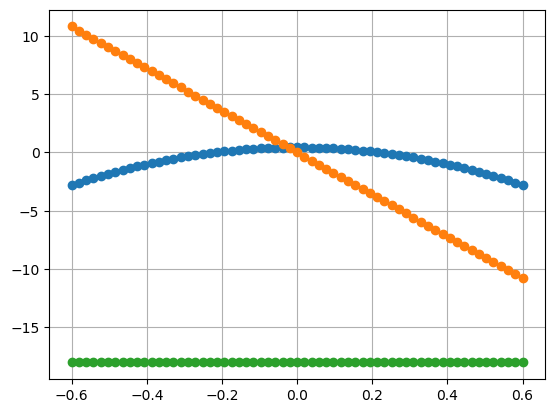

In [105]:
spl_C = Spline1D(x,C)
data_C_d1 = derivative(spl_C, x)
spl_C_d1 = Spline1D(x, data_C_d1)
data_C_d2 = derivative(spl_C_d1, x);

plt.clf()
plt.plot(x, C, marker="o")
plt.plot(x, data_C_d1, marker="o")
plt.plot(x, data_C_d2, marker="o")
plt.grid();

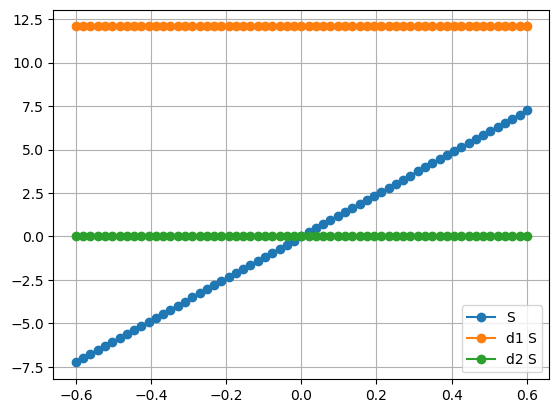

In [113]:
spl_S = Spline1D(x, phase)
data_S_d1 = derivative(spl_S, x)
spl_S_d1 = Spline1D(x, data_S_d1)
data_S_d2 = derivative(spl_S_d1, x);

plt.clf()
plt.plot(x, phase, marker="o", label="S")
plt.plot(x, data_S_d1, marker="o", label="d1 S")
plt.plot(x, data_S_d2, marker="o", label="d2 S")
plt.grid()
plt.legend();

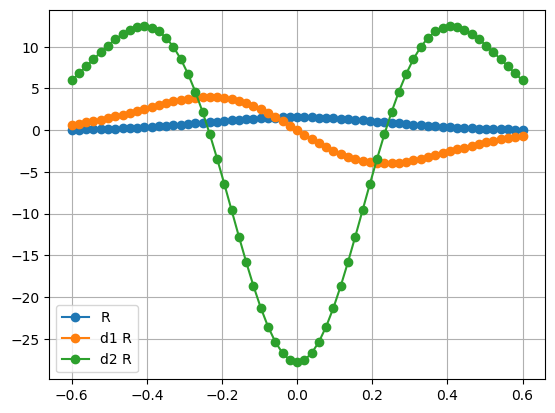

In [112]:
spl_R = Spline1D(x, R)
data_R_d1 = derivative(spl_R, x)
spl_R_d1 = Spline1D(x, data_R_d1)
data_R_d2 = derivative(spl_R_d1, x);

plt.clf()
plt.plot(x, R, marker="o", label="R")
plt.plot(x, data_R_d1, marker="o", label="d1 R")
plt.plot(x, data_R_d2, marker="o", label="d2 R")
plt.grid()
plt.legend();

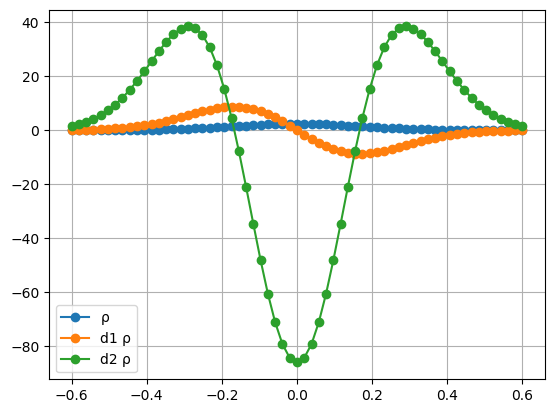

In [114]:
spl_ρ = Spline1D(x, ρ)
data_ρ_d1 = derivative(spl_ρ, x)
spl_ρ_d1 = Spline1D(x, data_ρ_d1)
data_ρ_d2 = derivative(spl_ρ_d1, x);

plt.clf()
plt.plot(x, ρ, marker="o", label="ρ")
plt.plot(x, data_ρ_d1, marker="o", label="d1 ρ")
plt.plot(x, data_ρ_d2, marker="o", label="d2 ρ")
plt.grid()
plt.legend();